In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from statsmodels.formula.api import ols

I grouped all residential rows.
I removed all null values of continuous variables and got rid of outliers for SalePrice and SqFtTotLiving

In [3]:
def rainbow_check(results):
    rainbow_statistic, rainbow_p_value = linear_rainbow(results)
    print("Rainbow statistic:", rainbow_statistic)
    print("Rainbow p-value:", rainbow_p_value)

def Homoscadasticity_check(df, results, features):
    y = df["SalePrice"]
    y_hat = results.predict()
    fig4, ax4 = plt.subplots()
    ax4.set(xlabel="Predicted Sale Price",
        ylabel="Residuals (Predicted - Actual Sale Price)")
    ax4.scatter(x=y_hat, y=y_hat-y, color="blue", alpha=0.2)
    plt.show()

    lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, df[features])
    print("Lagrange Multiplier p-value:", lm_p_value)
    print("F-statistic p-value:", f_p_value)

def vif_check(df, features):
    rows = df[features].values

    vif_df = pd.DataFrame()
    vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(len(features))]
    vif_df["feature"] = features
    print(vif_df)
def stat_checks(df, results, features):
    rainbow_check(results)
    Homoscadasticity_check(df, results, features)
    if len(features) > 1:
        vif_check(df, features)

In [2]:
residential_preprocessed = pd.read_csv('../../data/processed/residential_preprocessed.csv')
residential_processed = pd.read_csv('../../data/processed/residential_processed.csv')

In [4]:
fsm_df = residential_preprocessed[['BldgGrade', 'SalePrice']].copy()
fsm_df.dropna(inplace=True)
fsm = ols(formula="SalePrice ~ BldgGrade", data=fsm_df)
fsm_results = fsm.fit()

In [5]:
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     8407.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:08:28   Log-Likelihood:            -1.8275e+05
No. Observations:               13038   AIC:                         3.655e+05
Df Residuals:                   13036   BIC:                         3.655e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.067e+06   2.06e+04    -51.791      0.000   -1.11e+06   -1.03e+06
BldgGrade   2.335e+05   2546.581     91.689      0.000    2.29e+05    2.38e+05
==============================================================================
Omnibus:                     1091.214   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1610.023
Skew:                           0.667   Prob(JB):                         0.00
Kurtosis:                       4.089   Cond. No.                         65.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Rainbow statistic: 1.0469183588404274
Rainbow p-value: 0.03210543199376004


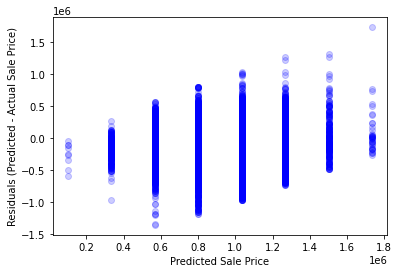

Lagrange Multiplier p-value: nan
F-statistic p-value: 0.0


In [6]:
stat_checks(fsm_df, fsm_results, ['BldgGrade'])

I can only explain about 39% of the variance in SalePrice, with only one feature it is statistically significant with an alpha level of 0.05. We violate the normality assumption with the probability of our JB value being 0. The rainbow stat check returned a p-value of 0.0321. Being below the mark of 0.05, this model violates the linearity assumption. Returning a p-value for our residuals this low means that this model violates the homoscedasticity assumption.

In [8]:
model_5_df = residential_processed[['BldgGrade', 'SqFtTotLiving_log', 'SalePrice', 
                                    'BathFullCount_log', 'Bedrooms_log']].copy()
model_5_df.dropna(inplace=True)
model_5 = ols(formula="""SalePrice ~ BldgGrade + SqFtTotLiving_log
                        + BathFullCount_log + Bedrooms_log""", data=model_5_df)
model_5_results = model_5.fit()

In [9]:
model_5_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     2552.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:09:32   Log-Likelihood:            -1.8177e+05
No. Observations:               13009   AIC:                         3.635e+05
Df Residuals:                   13004   BIC:                         3.636e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -6.149e+05   2.59e+04    -23.763      0.000   -6.66e+05   -5.64e+05
BldgGrade          1.782e+05   3189.105     55.882      0.000    1.72e+05    1.84e+05
SqFtTotLiving_log  1.117e+05   4236.633     26.369      0.000    1.03e+05     1.2e+05
BathFullCount_log   -1.2e+04   2961.676     -4.052      0.000   -1.78e+04   -6196.209
Bedrooms_log      -9263.2594   3389.587     -2.733      0.006   -1.59e+04   -2619.173
==============================================================================
Omnibus:                      735.568   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1046.814
Skew:                           0.509   Prob(JB):                    4.87e-228
Kurtosis:                       3.946   Cond. No.                         85.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Rainbow statistic: 1.0213753402093544
Rainbow p-value: 0.19692044739552245


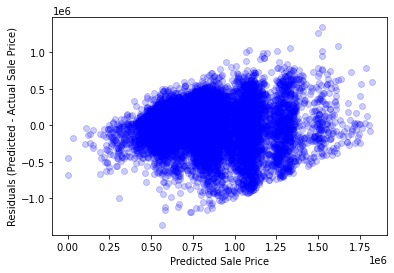

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0
        VIF            feature
0  1.000536          BldgGrade
1  2.019893  SqFtTotLiving_log
2  1.321374  BathFullCount_log
3  1.716025       Bedrooms_log


In [10]:
stat_checks(model_5_df, model_5_results, ['BldgGrade', 'SqFtTotLiving_log', 
                                          'BathFullCount_log', 'Bedrooms_log'])

I ended with being able to predict 44% of the variation, with violating the normality assumption due to the probability of the JB value is tiny. The homoscedasticty assumption was violated as well due to the check returning a value of 0. The model does not violate the linearity assumption and has very little multicolinearity.

With my model I could predict that with every increase of building grade, the sale price would increase by about 3200. For every added bedroom the sale price would increase by about 3400. And for every added full bathroom the sale price would increase by about 3000.

Due to the model having a relatively low R-squared, large JB value and violating the homoscedasticity check, I would have to say I am not very confident in this model and it doesnt answer the business question very well.

Next steps would be to investigate the data more to see if there are features that would group the data cleaner in order to better predict.